In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from store import *

In [2]:
store = Store(os.getenv('localappdata') + r'\Kaspad\kaspa-mainnet\datadir2')
store.load_blocks()

Pruning point:  d377399dfb9b4d21389228bff2c7abfbaeb1069867ecf53b3bbf292b373496f6
Loaded 40000 blocks
Loaded 80000 blocks
Loaded 120000 blocks
Loaded 160000 blocks
Loaded 200000 blocks
Loaded 240000 blocks
Loaded 280000 blocks
Overall number of headers:  296324


In [3]:
frames = store.load_data(['timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty'], ['pubkey_script'])

Loaded data of 10000 blocks
Loaded data of 20000 blocks
Loaded data of 30000 blocks
Loaded data of 40000 blocks
Loaded data of 50000 blocks
Loaded data of 60000 blocks
Loaded data of 70000 blocks
Loaded data of 80000 blocks
Loaded data of 90000 blocks
Loaded data of 100000 blocks
Loaded data of 110000 blocks
Loaded data of 120000 blocks
Loaded data of 130000 blocks
Loaded data of 140000 blocks
Loaded data of 150000 blocks
Loaded data of 160000 blocks
Loaded data of 170000 blocks
Loaded data of 180000 blocks
Loaded data of 190000 blocks
Loaded data of 200000 blocks
Loaded data of 210000 blocks
Loaded data of 220000 blocks
Loaded data of 230000 blocks
Loaded data of 240000 blocks
Loaded data of 250000 blocks
Loaded data of 260000 blocks
Loaded data of 270000 blocks
Loaded data of 280000 blocks
Loaded data of 290000 blocks
Number of headers missing header data:  1
Number of blocks missing block data:  1


In [4]:
frames.keys()

dict_keys(['hash', 'timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty', 'pubkey_script'])

In [5]:
num_parents_col, num_children_col = [], []
for h in frames['hash']:
    relations = store.get_block(h)
    num_parents = len(relations.parents)
    num_children = len(relations.children)
    num_parents_col.append(num_parents)
    num_children_col.append(num_children)

In [6]:
frames['num_parents'] = num_parents_col
frames['num_children'] = num_children_col

In [7]:
num_blues_col, num_reds_col = [], []
for h in frames['hash']:
    num_blues, num_reds = store.get_ghostdag_data(h)
    num_blues_col.append(num_blues)
    num_reds_col.append(num_reds)

In [8]:
frames['num_blues'] = num_blues_col
frames['num_reds'] = num_reds_col

In [9]:
df = pd.DataFrame(frames).set_index('hash')

In [10]:
pp_time = store.get_header_data(store.pruning_point()).timeInMilliseconds
pp_time

1642422266026

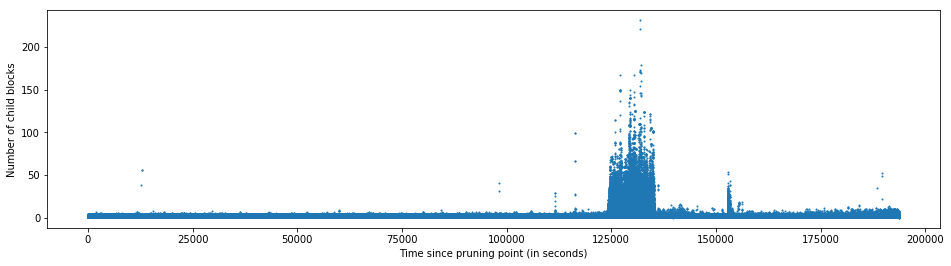

In [11]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_children'], s=1)
plt.ylabel('Number of child blocks')
plt.xlabel('Time since pruning point (in seconds)')
plt.show()

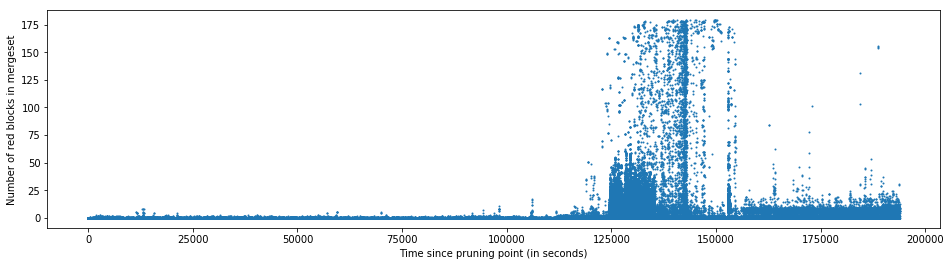

In [12]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_reds'], s=1)
plt.ylabel('Number of red blocks in mergeset')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'reds.png')
plt.show()

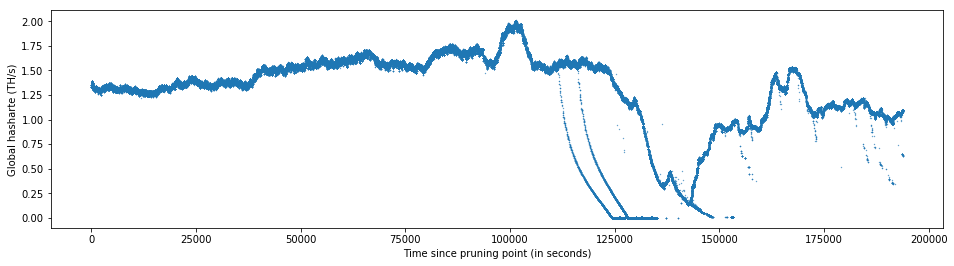

In [29]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['difficulty']*2/1000000000000, s=0.1)
plt.ylabel('Global hasharte (TH/s)')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'ghr.png')
plt.show()

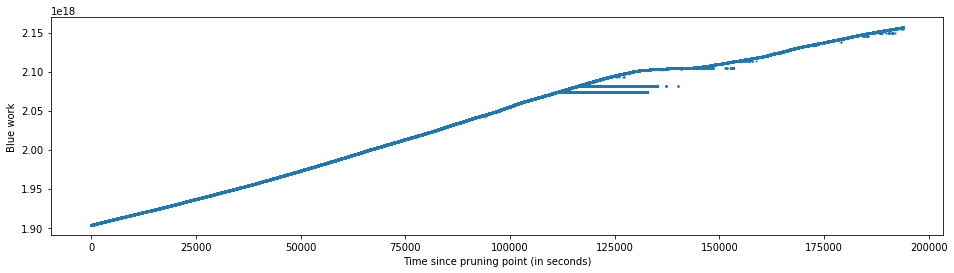

In [15]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueWork'], s=1)
plt.ylabel('Blue work')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'bw.png')
plt.show()

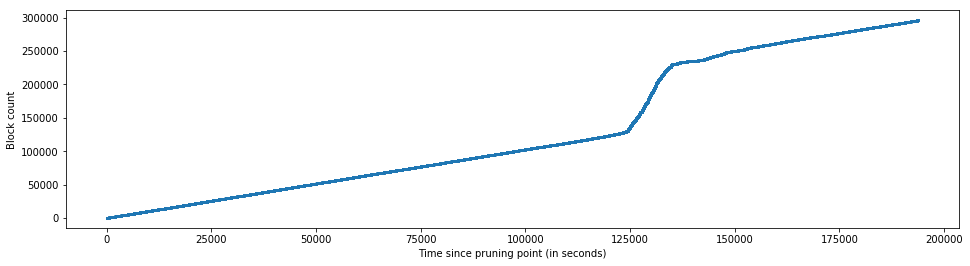

In [19]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, np.arange(len(df_sortedby_time['daaScore'])), s=1)
plt.ylabel('Block count')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'count.png')
plt.show()

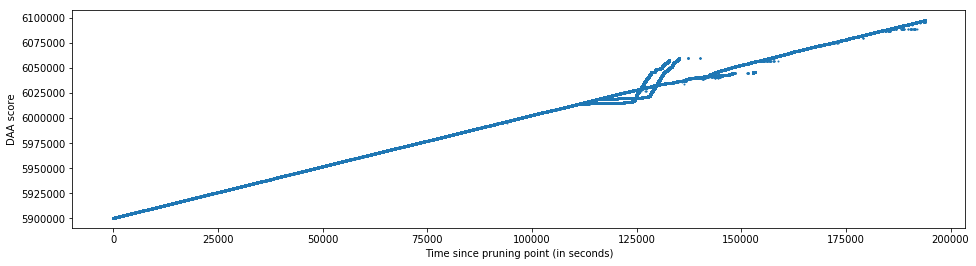

In [18]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, df_sortedby_time['daaScore'], s=1)
plt.ylabel('DAA score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'daa.png')
plt.show()

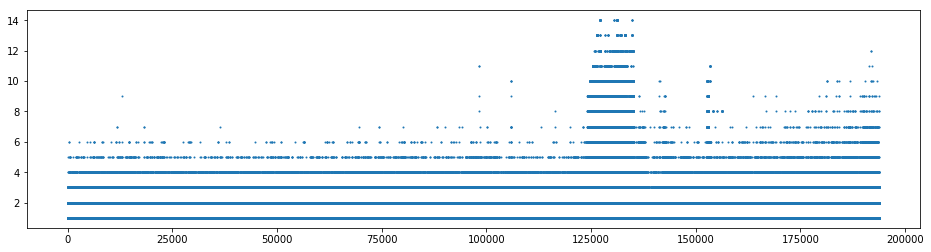

In [30]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_blues'], s=1)
plt.show()

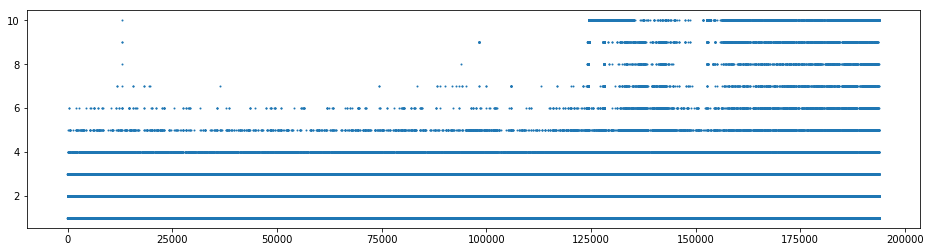

In [31]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_parents'], s=1)
plt.show()

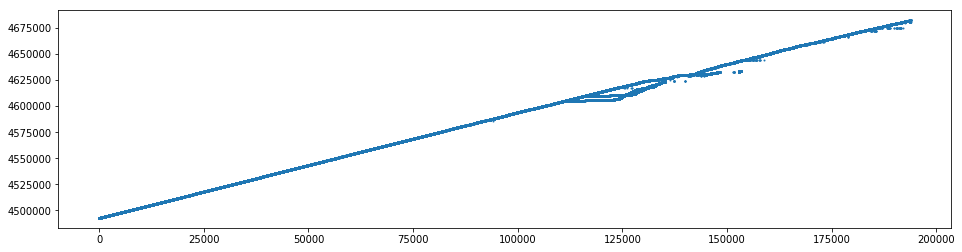

In [32]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueScore'], s=1)
plt.show()

In [17]:
df_sortedby_time = df.sort_values(by='timeInMilliseconds')

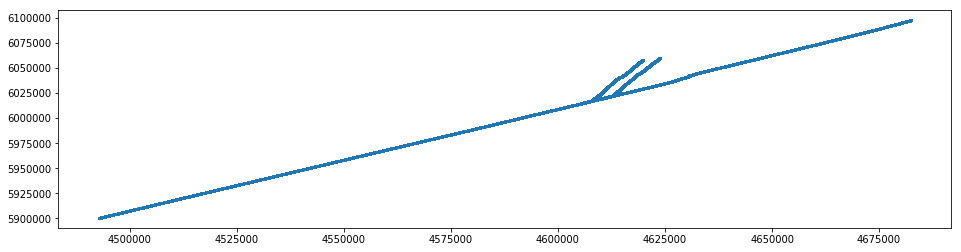

In [33]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueScore'], df['daaScore'], s=1)
plt.show()

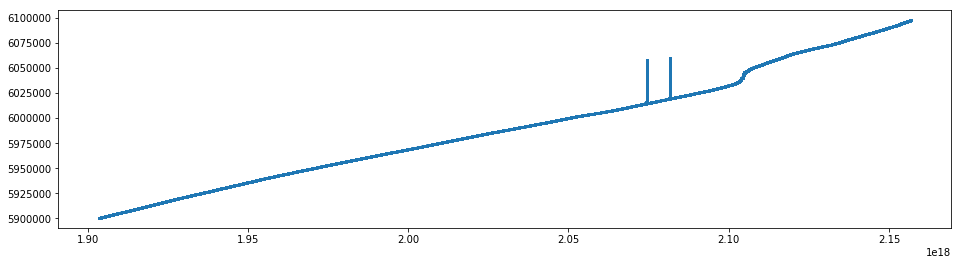

In [34]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueWork'], df['daaScore'], s=1)
plt.show()

In [22]:
df_groupedby_miner = df.groupby('pubkey_script')

In [23]:
len(df_groupedby_miner)

576

In [24]:
# TODO: explore mining addresses of red blocks 

In [25]:
store.close()